# Spotify Podcast Dataset - Publisher



In [273]:
import pandas as pd
import altair as alt
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

In [274]:
df = pd.read_csv('../../podcasts-no-audio-13GB-selected/metadata_with_episode_dates_and_category.tsv',sep='\t')
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y-%m-%d').reset_index(drop=True)

# Dataset is constrained to start_date and end_date
#start_date = pd.to_datetime("2019-01-01")
#end_date = pd.to_datetime("2020-03-01")

# Filter the DataFrame to include only rows between start_date and end_date
#df = df[(df.release_date >= start_date) & (df.release_date <= end_date)]

In [275]:
df.shape

(105360, 18)

In [276]:
df.columns

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'release_date', 'first_dir', 'second_dir', 'category',
       'mean_show_duration', 'top_5'],
      dtype='object')

# Publisher Specific Insights

In [277]:
df['publisher'].unique()

array(['Katie Houle', 'Morning Cup Of Murder', 'Inside the 18 GK Media',
       ..., 'High Schooler ', 'Zach Valen', 'Chelsea Batalla'],
      dtype=object)

## Publisher Summary Stats

In [278]:
df_ss = df[df['publisher']=='Spotify Studios']

In [279]:
df_ss.shape

(1252, 18)

In [280]:
df_pub_barchart_values = np.array([
    # number of shows
    df_ss['show_filename_prefix'].unique().shape[0],
    # number of total episodes
    df_ss['episode_filename_prefix'].unique().shape[0],
    # average number of episodes per show
    df_ss.groupby('show_filename_prefix').size().mean()
])
df_pub_barchart_values

array([  47.        , 1252.        ,   26.63829787])

In [281]:
df_pub_barchart_categories = np.array(['number_of_shows', 'number_of_episodes', 'mean_number_of_episodes_per_show'])

In [282]:
cols = ['Category','Values']
df_pub_barchart = pd.DataFrame(np.array([df_pub_barchart_categories, df_pub_barchart_values]).T, columns=cols)
df_pub_barchart

,Category,Values
0,number_of_shows,47.0
1,number_of_episodes,1252.0
2,mean_number_of_episodes_per_show,26.638297872340427


In [283]:
df_pub_barchart.dtypes

Category    object
Values      object
dtype: object

In [284]:
# bar chart of number of shows, number of episodes, number of episodes per show
bar_chart = alt.Chart(df_pub_barchart).mark_bar().encode(
    x='Values:Q',  # Quantitative scale for the y-axis
    y=alt.X('Category:N'),
    tooltip=['Values']
).configure_scale(
    bandPaddingInner=0.2,
)

bar_chart = bar_chart.properties(width=300, height=200)
bar_chart.save('publisher_summary_bar_chart.json')
bar_chart

alt.Chart(...)

## Publisher Timeseries Stats

In [285]:
df.columns

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'release_date', 'first_dir', 'second_dir', 'category',
       'mean_show_duration', 'top_5'],
      dtype='object')

In [286]:
df.dtypes

show_uri                           object
show_name                          object
show_description                   object
publisher                          object
language                           object
rss_link                           object
episode_uri                        object
episode_name                       object
episode_description                object
duration                          float64
show_filename_prefix               object
episode_filename_prefix            object
release_date               datetime64[ns]
first_dir                           int64
second_dir                         object
category                           object
mean_show_duration                float64
top_5                              object
dtype: object

In [287]:
df['release_date']

0        2019-12-18
1        2020-01-30
2        2019-01-18
3        2019-03-01
4               NaT
            ...    
105355   2019-03-29
105356   2019-05-04
105357   2019-01-08
105358   2019-06-25
105359   2019-10-27
Name: release_date, Length: 105360, dtype: datetime64[ns]

In [288]:
df_ss = df[df['publisher']=='Spotify Studios']

In [289]:

# First group by show name AND aggregate time by month AND THEN get the counts which will give you the episodes per month by show for every month.
# then take the average over all months to get the average episodes per month by show. 
monthly_counts = df_ss[['show_name','release_date']].groupby(['show_name',df_ss.release_date.dt.to_period("M")]).agg('count') \
    .groupby('show_name').mean().sort_values(by='release_date',ascending=False)
monthly_counts = monthly_counts.reset_index()

# Reset the index to have 'Date' as a column again
monthly_counts['episodes_per_month'] = monthly_counts['release_date']
monthly_counts.drop('release_date',axis=1,inplace=True)
# Display the resulting DataFrame
monthly_counts.head()


,show_name,episodes_per_month
0,The Hottest Take,15.000000
1,Spotify x IPG Mediabrands,12.000000
2,21 Days with mxmtoon,8.000000
3,Jemele Hill is Unbothered,7.545455
4,Identify,7.000000


In [290]:
monthly_counts.head()

,show_name,episodes_per_month
0,The Hottest Take,15.000000
1,Spotify x IPG Mediabrands,12.000000
2,21 Days with mxmtoon,8.000000
3,Jemele Hill is Unbothered,7.545455
4,Identify,7.000000


In [291]:
# bar chart of number of shows, number of episodes, number of episodes per show
bar_chart2 = alt.Chart(monthly_counts).mark_bar().encode(
    x=alt.X('episodes_per_month:Q'),  # Quantitative scale for the y-axis
    y=alt.Y('show_name:N').sort('-x')
).configure_scale(
    bandPaddingInner=0.2,
)

bar_chart2 = bar_chart2.properties(width=300, height=500)
bar_chart2.save('publisher_episodes_by_month_bar_chart.json')
bar_chart2


alt.Chart(...)

# General Insights for Publishers

## Find Shows by Publisher

In [292]:
df_pub2show = df.groupby(['publisher','show_name']).size().sort_values(ascending=False).reset_index().groupby('publisher').size().sort_values(ascending=False)
df_pub2show = pd.DataFrame(df_pub2show, columns=['Number of Shows']).reset_index()
# Calculate circle sizes based on 'Value'
#df_pub2show['CircleSize'] = np.sqrt(df_pub2show['Number of Shows'])
df_pub2show['Number of Shows Jitter'] = df_pub2show['Number of Shows'] + np.abs(np.random.normal(0,1,(len(df_pub2show),)))

## Find Episodes by Publisher

In [293]:
df_pub2episode = df.groupby('publisher').size().sort_values(ascending=False)
df_pub2episode = pd.DataFrame(df_pub2episode, columns=['Number of Episodes']).reset_index()
# Calculate circle sizes based on 'Value'
df_pub2episode['CircleSize'] = np.sqrt(df_pub2episode['Number of Episodes'])
df_pub2episode['Number of Episodes Jitter'] = df_pub2episode['Number of Episodes'] + np.abs(np.random.normal(0,1,(len(df_pub2show),)))
df_pub2episode.shape

(17490, 4)

In [294]:
df_pub = df_pub2episode.merge(df_pub2show,on='publisher',how='left')

## Plot of All Publishers

In [295]:
import altair as alt
import pandas as pd
import numpy as np

# Create a scatter plot with circles to represent the categorical table
circle_table = alt.Chart(df_pub.sample(5000)).mark_circle().encode(
    x=alt.X('publisher:O', axis=alt.Axis(labels=False, title='')),
    y=alt.Y('Number of Episodes Jitter:Q', scale=alt.Scale(type='log'), axis=alt.Axis(labels=False, title='')),
    size=alt.Size('CircleSize:Q', scale=alt.Scale(range=[5, 2000]), legend=None),  # Adjust size range as needed
    #color=alt.Color('publisher:N', legend=None),
    color=alt.Color(scale=alt.Scale(scheme='blueorange-8')),
    tooltip=['publisher:N', 'Number of Episodes:Q','Number of Shows:Q']  # Add a tooltip with 'Category' and 'Value'
).properties(
    width=600,
    height=600,
    title='Podcast Publishers (Hover Over)'
).configure_title(
    fontSize=16,
    anchor='middle'
).configure_axis(
    grid=False  # Remove gridlines
).configure_axisY(
    ticks=False
)

circle_table

alt.Chart(...)

In [296]:
df_ss.columns

Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'release_date', 'first_dir', 'second_dir', 'category',
       'mean_show_duration', 'top_5'],
      dtype='object')

## Single Publisher Word Cloud

df_ss.cateory

In [316]:
df_filtered = df[~df['category'].isna()]
df_filtered.shape

(105268, 18)

In [ ]:
df_ss = df_filtered[df_filtered['publisher']=='Spotify Studios']

In [336]:
category_raw_counts = []
for i,val in df_ss['category'].items():
   category_raw_counts.extend(val.split(','))
len(category_raw_counts)

2459

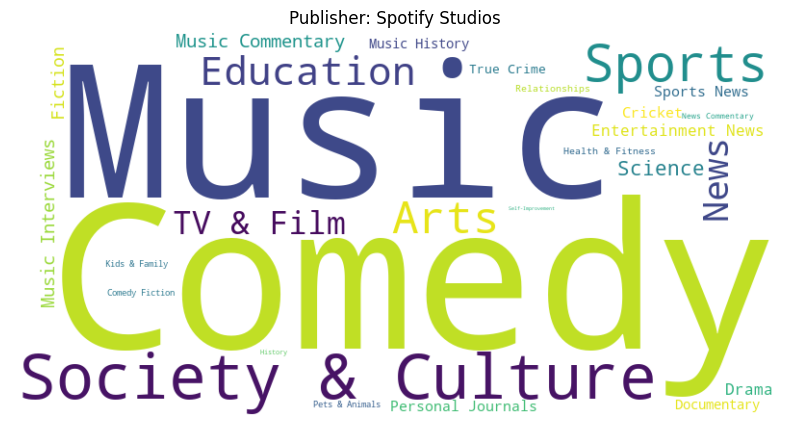

In [337]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

category_counts = Counter(category_raw_counts)
sorted_counts = dict(sorted(category_counts.items(), key=lambda item: item[1], reverse=True))
values, frequencies = zip(*sorted_counts.items())

# Generate the word cloud with the specified font
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Publisher: Spotify Studios')
plt.show()

In [338]:
wc.to_file(filename='publisher_word_cloud.png')

In [339]:
category_list = [k for k,v in sorted_counts.items()]
frequency_list = [v for k,v in sorted_counts.items()]
cat_df = pd.DataFrame(np.array([category_list, frequency_list]).T,columns=['Categories','Frequency'])


In [343]:
# bar chart

bar_chart3 = alt.Chart(cat_df).mark_bar().encode(
    x=alt.X('Frequency:Q'),  # Quantitative scale for the y-axis
    y=alt.Y('Categories:N').sort('-x')
).configure_scale(
    bandPaddingInner=0.2,
).properties(
    width=1000,
    height=600,
    title='Podcast Show Categories'
).configure_axisY(
    titleAlign='left',  # Align the title to the left
    titleAnchor='end',  # Set the title anchor to the end
    labelAlign='right',  # Align the labels to the right
)

#bar_chart2 = bar_chart2.properties(width=300, height=500)
#bar_chart2.save('publisher_episodes_by_month_bar_chart.json')
bar_chart3

alt.Chart(...)